## What are the effects of pupil and behavior on neuronal activity in A1?

1) Active vs Passive -- do we see a change in gain? -- Bar plot with distributions (similar to previous plots) for AC and IC

2) Pre-passive vs post-passives -- do we see a change there? Motivation for what comes next. -- Bar plot as well? for AC and IC

3) Pupil diameter -- how much does pupil change explain A/P change? -- examples and explained variance all data plot for AC and IC. For this we used both Modulation Indexes (MI) and cross-val R2. 

4) Per trial performance -- FAR+Hits=large pupil and Misses=small pupil, we would expect adding per trial performance to contribute to better model predictions, but we saw no improvement

5) Smoothed performance -- same question as 4) but different way of addressing it by smoothing animal performance over a minute time window -- small effect that indicate no interaction between pupil effect and animal's averaged performance -- not sure what's best way to show this

6) Urgency -- does animal's thirstiness/motivation to lick affect modulations? lick rate -- OPEN QUESTION

In [67]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as ss
import statsmodels.formula.api as smf
import matplotlib.collections as clt
import re
import pylab as pl

%matplotlib inline

savefigs = True
figs_dir = '/Users/daniela/Documents/2018/AC_IC_project_2018/Task_engagement_pupil_paper/figures'
path=os.getcwd()
path

'/Users/daniela/Documents/2018/AC_IC_project_2018/from_auto_daniela'

### 1) Do we see any modulation happening across passive behavior blocks? 

In [91]:
# pup vs. pre/post passive
#state_list = ['st.pup0.pas0','st.pup0.pas',
#            'st.pup.pas0','st.pup.pas']
#basemodel = "-ref-pas-psthfr.s_stategain.S"
#d_pup_pas = get_model_results(batch=batch, state_list=state_list, basemodel=basemodel)
d_pup_pas = pd.read_csv('d_pup_pas.csv')

In [92]:
# add column to specify if cellid has significant effect of any state variable 
# (specific to baseline row)
d_pup_pas['sig_var']=np.where(d_pup_pas['r_unique']>2*d_pup_pas['r_se'], 1, 0)

# next is an unelegant trick to get the values in raws that are not 'baseline' off the equation
mask = d_pup_pas.state_chan != 'baseline'
column = 'sig_var'
d_pup_pas.loc[mask, column] = '-'

# I want to delete that first Unnamed: 0 column because it's useless
d_pup_pas = d_pup_pas.drop(['Unnamed: 0'], axis=1)


In [93]:
d_pup_pas.head()

,cellid,modelname,state_sig,state_sig0,state_chan,MI,r,r_se,d,g,MI0,r0,r0_se,r_unique,MI_unique,sig_var
0,TAR010c-43-1,psth.fs20.pup-ld-st.pup.pas-ref-pas-psthfr.s_s...,st.pup.pas,st.pup0.pas0,baseline,NaN,0.765457,0.015730,1.048298,1.139909,NaN,0.688041,0.034295,0.077416,NaN,1
1,TAR010c-43-1,psth.fs20.pup-ld-st.pup.pas-ref-pas-psthfr.s_s...,st.pup.pas,st.pup0.pas,pupil,0.334014,0.765457,0.015730,0.359098,0.080382,0.078216,0.702159,0.026908,0.063298,0.255798,-
2,TAR010c-43-1,psth.fs20.pup-ld-st.pup.pas-ref-pas-psthfr.s_s...,st.pup.pas,st.pup.pas0,FILE_TAR010c12_p_PTD,-0.163315,0.765457,0.015730,0.197340,-0.088222,-0.211635,0.765529,0.015583,-0.000072,0.048319,-
3,BRT037b-33-1,psth.fs20.pup-ld-st.pup.pas-ref-pas-psthfr.s_s...,st.pup.pas,st.pup0.pas0,baseline,NaN,0.499735,0.014407,0.246346,0.881366,NaN,0.487300,0.017451,0.012435,NaN,0
4,BRT037b-33-1,psth.fs20.pup-ld-st.pup.pas-ref-pas-psthfr.s_s...,st.pup.pas,st.pup0.pas,pupil,0.224935,0.499735,0.014407,0.075438,0.123602,0.056144,0.491089,0.017232,0.008646,0.168791,-


## d_pup_pas dataframe columns explained

* **cellid**: unique name of the cell (either SUA or MUA)

* **modelname**: modelname used to predict these responses (NEMS)

* **state_sig**: for this data frame is always st.pup_pas indicating that pupil and passive blocks are the two state variables in this model.

* **state_sig0**: indicates the state variable that is shuffled in that row

* **state_chan**: the independent state variable, i.e, the thing whose effect is being tested in that row. e.g. pupil row will have pupil shuffled in the 0 conditions (st.pup0_pas)

* **MI**: MI for state_chan *pupil* and state_sig0 *st.pup0_pas* is the difference in the predicted response during large and small pupil and tells you how well a passive only model accounts for the pupil effect. MI for state_chan *FILE* and state_sig0 *st.pup_pas0* is the difference in the predicted response during that passive and the first passive and tells you how well a pupil only model accounts for passive block effect.

* **MI0**: MI0 for state_chan *pupil* and state_sig0 *st.pup0_beh* is the difference in the predicted response by the model with pupil shuffled. MI0 for state_chan *FILE* and state_sig0 *st.pup_pas0* is the difference in the predicted response by the model with passive block shuffled.

* **r**: Pearson's correlation between actual and the predicted response of the full model (st.pup_pas) and it's the same for every state_chan

* **r0**: Pearson's correlation between actual and predicted response of state_chan *pupil* and state_sig0 *st.pup0_pas* is the predicted response of the partial model where pupil is shuffled. r0 for state_chan *FILE* and state_sig0 *st.pup_pas0* is the predicted response of the partial model where passive block is shuffled.

* **MI_unique**: MI_unique for state_chan *pupil* and state_sig0 *st.pup0_beh* is MI calculated from the predicted response to large/small pupil in the full model minus MI calculated from the predicted response to large/small pupil when pupil is shuffled. MI_unique for state_chan *FILE* and state_sig0 *st.pup_pas0* is MI calculated from the predicted response for passive block in the full model minus MI calculated from the predicted response for passive block when passive block is shuffled.

* **R2**: Pearson's squared. R2 for both state_chan *pupil* and state_sig0 *st.pup0_beh* and state_chan *FILE* and state_sig0 *st.pup_pas0* is r from the full model with both passive block and pupil st.pup_pas squared.

* **R02**: Pearson's squared. R02 for state_chan *pupil* and state_sig0 *st.pup0_beh* is the r0 for pupil squared. R02 for state_chan *FILE* and state_sig0 *st.pup_pas0* is the r0 for passive block squared.

* **R2_unique**: Pearson's squared. R2_unique for state_chan *pupil* and state_sig0 *st.pup0_beh* is R2-R02 for pupil. R2_unique for state_chan *FILE* and state_sig0 *st.pup_pas0* is R2-R02 for passive block. 

In [94]:
# really bad way of deleting raws with passive comparisons that are not pre-post1
def just_the_first_passive(df):
    '''Returns a new dataframe with all the rows in df, except
    rows that are not the first passive. '''
    rows=[]
    cells_with_one_pup_pas0 = set()
    baseline = None
    pupil = None
    passive = None
    for _, row in df.iterrows():
        if (row['cellid'] in cells_with_one_pup_pas0):
            continue
        
        if (row['state_chan'] == 'baseline'):
            baseline = row
        if (row['state_chan'] == 'pupil'):
            pupil = row 
        if (row['state_sig0'] == 'st.pup.pas0'):
            passive = row
        
        if (baseline is not None and pupil is not None and passive is not None) and\
           (baseline['cellid'] == pupil['cellid']) and\
           (baseline['cellid'] == passive['cellid']):
            rows.append(baseline)
            rows.append(pupil)
            rows.append(passive)
            cells_with_one_pup_pas0.add(pupil['cellid'])
            baseline = None
            pupil = None
            passive = None

    return pd.DataFrame(rows)


In [95]:
d_pup_pas1 = just_the_first_passive(d_pup_pas)
#d_pup_pas1
#for cellid, group in d_pup_pas1.groupby('cellid'):
    #print(cellid)
    #assert len(group) == 3

In [96]:
# function to create a list of color names based on significant state variable effect 
# in A1 cells
def pltcolor(lst,state):
    colors=[]
    for val in lst:
        if val==0:
            colors.append('lightgrey')
        elif val==1 and state=='pas':
            colors.append('#D199C4')
        elif val==1 and state=='pup':
            colors.append('#2E7E3E')
    return colors

In [97]:
# Create three dataframes uniquely for each model
d_pup0_pas10=d_pup_pas1[d_pup_pas1['state_sig0']=='st.pup0.pas0']
d_pup0_pas1=d_pup_pas1[d_pup_pas1['state_sig0']=='st.pup0.pas']
d_pup_pas10=d_pup_pas1[d_pup_pas1['state_sig0']=='st.pup.pas0']

# gotta reset the inexes to that it does not complain in the next cell when I try
# to subtract two rows from two different data frame. I could have also merge these three 
# into one, but I'm lazy
d_pup0_pas10=d_pup0_pas10.reset_index(drop=True)
d_pup0_pas1=d_pup0_pas1.reset_index(drop=True)
d_pup_pas10=d_pup_pas10.reset_index(drop=True)

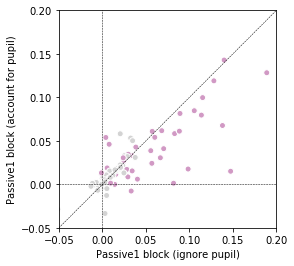

In [100]:
# Plotting passive block ignoring pupil versus passive block regressing out pupil
# x-axis improvement from passive block ignoring pupil:  r_pup0_pas1 - r_pup0_pas10
# y-axis improvement regressing out (or accounting for) pupil: r_pup_pas1 - r_pup_pas10

# Create the colors list using the function pltcolor
colors=pltcolor(d_pup_pas1['sig_var'],'pas')

fig, ax = plt.subplots()

# set the limits
plt.ylim(-0.05, 0.2)
plt.xlim(-0.05, 0.2)

# draw horizontal lines and unitary line
plt.axhline(0, linestyle='--', linewidth=0.5, color='k')
plt.axvline(0, linestyle='--', linewidth=0.5, color='k')
plt.plot([-0.05,0.2],[-0.05, 0.2], linestyle='--',linewidth=0.5, color='k')

# note that d_pup0_beh['r'] is the same as d_pup_beh0['r'] and d_pup0_beh0['r']
ax.scatter(d_pup0_pas1['r0']-d_pup0_pas10['r0'],d_pup_pas10['r']-d_pup_pas10['r0'], 
           color=colors, edgecolors='white')
ax.set_xlabel('Passive1 block (ignore pupil)')
ax.set_ylabel('Passive1 block (account for pupil)')
ax.set_aspect('equal')

plt.savefig("passive_A1.eps")


## 3) What is the contribution of pupil to behavioral effects?

### a) A1 MUA+SUA pupil/behavior

In [78]:
# pup vs. active/passive A1 SUA+MUA
d_pup_beh = pd.read_csv('d_pup_beh.csv')

In [79]:
# to look at unique variance explained we need to square r and r0 and then take the difference
# create three new colums R2 R02 and delta_R2
d_pup_beh['R2']=d_pup_beh['r']**2
d_pup_beh['R02']=d_pup_beh['r0']**2
d_pup_beh['R2_unique']=d_pup_beh['R2']-d_pup_beh['R02']

# Also I want to delete that first Unnamed column because it's useless
d_pup_beh = d_pup_beh.drop(['Unnamed: 0'], axis=1)

In [80]:
# add column to specify if cellid has significant effect of any state variable 
# (specific to baseline row)
d_pup_beh['sig_var']=np.where(d_pup_beh['r_unique']>2*d_pup_beh['r_se'], 1, 0)

# next is an unelegant trick to get the values in raws that are not 'baseline' off the equation
mask = d_pup_beh.state_chan != 'baseline'
column = 'sig_var'
d_pup_beh.loc[mask, column] = '-'

d_pup_beh.head()

,cellid,modelname,state_sig,state_sig0,state_chan,MI,r,r_se,d,g,MI0,r0,r0_se,r_unique,MI_unique,R2,R02,R2_unique,sig_var
0,BRT037b-63-1,psth.fs20.pup-ld-st.pup.beh-ref-psthfr.s_state...,st.pup.beh,st.pup0.beh0,baseline,NaN,0.743903,0.019168,2.987447,0.975693,NaN,0.743709,0.018425,0.000195,NaN,0.553392,0.553102,0.000290,0
1,BRT037b-63-1,psth.fs20.pup-ld-st.pup.beh-ref-psthfr.s_state...,st.pup.beh,st.pup0.beh,pupil,0.016711,0.743903,0.019168,0.026076,-0.004084,0.008893,0.744072,0.019048,-0.000168,0.007819,0.553392,0.553643,-0.000250,-
2,BRT037b-63-1,psth.fs20.pup-ld-st.pup.beh-ref-psthfr.s_state...,st.pup.beh,st.pup.beh0,active,0.017977,0.743903,0.019168,0.108336,0.058744,0.006886,0.743838,0.018794,0.000065,0.011091,0.553392,0.553296,0.000097,-
3,BRT037b-30-1,psth.fs20.pup-ld-st.pup.beh-ref-psthfr.s_state...,st.pup.beh,st.pup0.beh0,baseline,NaN,0.775877,0.013483,2.051010,0.972697,NaN,0.776267,0.013080,-0.000391,NaN,0.601984,0.602591,-0.000607,0
4,BRT037b-30-1,psth.fs20.pup-ld-st.pup.beh-ref-psthfr.s_state...,st.pup.beh,st.pup0.beh,pupil,0.007358,0.775877,0.013483,0.037487,-0.018406,0.004439,0.776262,0.013404,-0.000385,0.002919,0.601984,0.602583,-0.000598,-


In [81]:
# function to create a list of color names based on significant state variable effect 
# in A1 cells
def pltcolor(lst,state):
    colors=[]
    for val in lst:
        if val==0:
            colors.append('lightgrey')
        elif val==1 and state=='beh':
            colors.append('#82418B')
        elif val==1 and state=='pup':
            colors.append('#2E7E3E')
    return colors

In [82]:
# Create three dataframes uniquely for each model
d_pup0_beh0=d_pup_beh[d_pup_beh['state_chan']=='baseline']
d_pup0_beh=d_pup_beh[d_pup_beh['state_chan']=='pupil']
d_pup_beh0=d_pup_beh[d_pup_beh['state_chan']=='active']

# gotta reset the inexes to that it does not complain in the next cell when I try
# to subtract two rows from two different data frame. I could have also merge these three 
# into one, but I'm lazy
d_pup0_beh0=d_pup0_beh0.reset_index(drop=True)
d_pup0_beh=d_pup0_beh.reset_index(drop=True)
d_pup_beh0=d_pup_beh0.reset_index(drop=True)

In [83]:
mean_g_beh=d_pup0_beh['g'].mean()
std_g_beh=d_pup0_beh['g'].std()
print(mean_g_beh)
print(std_g_beh)

mean_g_pas1=d_pup0_pas1['g'].mean()
std_g_pas1=d_pup0_pas1['g'].std()
print(mean_g_pas1)
print(std_g_pas1)

0.06172905802508164
0.21276935691695734
0.08005038683118096
0.20781178688246635


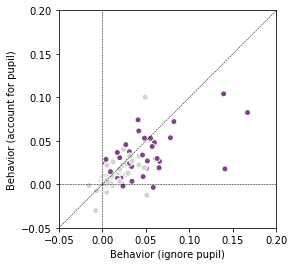

In [89]:
# Plotting behavior ignoring pupil versus behavior regressing out pupil
# x-axis improvement from behavior ignoring pupil:  r_pup0_beh - r_pup0_beh0
# y-axis improvement regressing out (or accounting for) pupil: r_pup_beh - r_pup_beh0

# Create the colors list using the function pltcolor
colors=pltcolor(d_pup_beh['sig_var'],'beh')

fig, ax = plt.subplots()

# set the limits
plt.ylim(-0.05, 0.2)
plt.xlim(-0.05, 0.2)

# draw horizontal lines and unitary line
plt.axhline(0, linestyle='--', linewidth=0.5, color='k')
plt.axvline(0, linestyle='--', linewidth=0.5, color='k')
plt.plot([-0.05,0.2],[-0.05, 0.2], linestyle='--',linewidth=0.5, color='k')

# note that d_pup0_beh['r'] is the same as d_pup_beh0['r'] and d_pup0_beh0['r']
ax.scatter(d_pup0_beh['r0']-d_pup0_beh0['r0'],d_pup_beh0['r']-d_pup_beh0['r0'], 
           color=colors, edgecolors='white')
ax.set_xlabel('Behavior (ignore pupil)')
ax.set_ylabel('Behavior (account for pupil)')
ax.set_aspect('equal')

plt.savefig("behaviorVSpupil_A1.eps")


**Questions to be answered**
* How many of these are SUA versus MUA?
* Can we tell if those cells above the unitary lines have negative r_unique for pupil or negative full model r? MI?


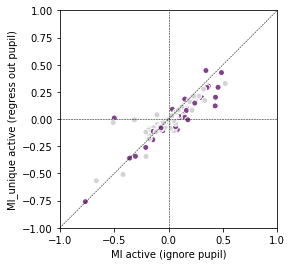

In [88]:
# Plot unique contribution of pupil in terms of MI. 
# x axis is MI for a variable behavior  if you ignore the existence of pupil
# y axis is MI_unique for behavior, MI behavior after regressing out pupil

# d_pup_beh0['MI] is the MI calculated from the full model for active and passive behavior
# d_pup0_beh['MI'] is the MI calculated from the full model for large and small pupil

fig, ax = plt.subplots()

ax.scatter(d_pup_beh0['MI'], d_pup_beh0['MI_unique'], color=colors, edgecolors='white')
ax.set_xlabel('MI active (ignore pupil)')
ax.set_ylabel('MI_unique active (regress out pupil)')
ax.set_aspect('equal')

# set the limits
plt.ylim(-1, 1)
plt.xlim(-1, 1)

# need a slope and c to fix the position of line
slope = 1
c = -1

x_min, x_max = ax.get_xlim()
y_min, y_max = c, c + slope*(x_max-x_min)
ax.plot([x_min, x_max], [y_min, y_max], linewidth=0.5, linestyle='--', color='k')
ax.set_xlim([x_min, x_max])


# add horizontal line
slope = 0
c = 0

x_min, x_max = ax.get_xlim()
y_min, y_max = c, c + slope*(x_max-x_min)
ax.plot([x_min, x_max], [y_min, y_max], linewidth=0.5, linestyle='--', color='k')
ax.set_xlim([x_min, x_max])

# add vertical line
xposition = 0.00
plt.axvline(x=xposition, color='k', linestyle='--', linewidth=0.5)

plt.savefig("behaviorVSpupil_MI_A1.eps")

Stacked bar char: for each cell plot a bar broken up into 4 colors showing the relative performance of the null model (r_pup0.beh0), unique pupil (r_pup.beh-r_pup0.beh), unique behavior (r_pup.beh-r_pup.beh0) and ambiguous pupil or behavior (r_pup0.beh + r_pup.beh0 - r_pup.beh - r_pup0.beh0 -- I think the math works out for this last one).

### a) A1 SUA pupil/behavior